# Background


The violation of the CHSH inequality with the Estimator primitive will be proven here by the usage of a quantum circuit.

# Step 1. Map classical problem to quantum circuit

We create an entangled pair on which we measure each qubit on two different bases. If quantum mechanics can be described by local hidden variables theories, the following inequality must hold true. This can be violated by quantum computers, disproving such theories:

$$ | \langle S_2 \rangle | = |\langle AB \rangle + \langle Ab \rangle - \langle aB \rangle + \langle ab \rangle| \leq 2$$

where A and a are the bases for the first qubit, and B and b for the second one.

We will use the Bell state $| \Phi^+ \rangle$, and by using the Estimator primitive we will obtain the expectation values $\langle ... \rangle$ needed.

You will measure the second qubit in the $Z$ and $X$ bases. The first qubit will be measured also in orthogonal bases, but with an angle with respect to the second qubit, which we are going to sweep between $0$ and $2π$. As you will see, the Estimator primitive makes running parameterized circuits very easy. Rather than creating a series of CHSH circuits, you only need to create one CHSH circuit with a parameter specifying the measurement angle and a series of phase values for the parameter.

Finally, you will analyze the results and plot them against the measurement angle. You will see that for certain range of measurement angles, the expectation values of CHSH quantities $|\langle S_1 \rangle| \lt 2$ or $|\langle S_2 \rangle| \lt 2$, which demonstrates the violation of the CHSH inequality.

In [2]:
import numpy as np

from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.quantum_info import SparsePauliOp

from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2

import matplotlib.pyplot as plt
import matplotlib.ticker as tck

In [3]:
# To run on hardware, select the backend with the fewest number of jobs in the queue
service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.least_busy(operational=True, simulator=False, min_num_qubits=127)
backend.name

'ibm_sherbrooke'

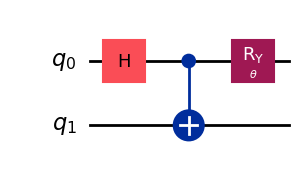

In [7]:
theta = Parameter("$\\theta$")

chsh_circuit = QuantumCircuit(2)
chsh_circuit.h(0)
chsh_circuit.cx(0, 1)
chsh_circuit.ry(theta, 0)
chsh_circuit.draw("mpl", idle_wires=False, style="iqp")

In [10]:
# We create a list of phase values to be assigned to the circuit in the next step.

number_of_phases = 21
phases = np.linspace(0, 2 * np.pi, number_of_phases)
# Phases needed to be expressed as list of lists in order to work
individual_phases = [[ph] for ph in phases]

# Now we need observables from which to compute the expectation values. In our case we are looking at orthogonal bases for each qubit, 
# letting the parameterized Y rotation for the first qubit sweep the measurement basis nearly continuously with respect to the second 
# qubit basis. We will therefore choose the observables ZZ, ZX, XZ, and XX.

# <CHSH1> = <AB> - <Ab> + <aB> + <ab> -> <ZZ> - <ZX> + <XZ> + <XX>
observable1 = SparsePauliOp.from_list([("ZZ", 1), ("ZX", 1), ("XZ", 1), ("XX", 1)])

# <CHSH2> = <AB> + <Ab> - <aB> + <ab> -> <ZZ> + <ZX> - <XZ> + <XX>
observable2 = SparsePauliOp.from_list([("ZZ", 1), ("ZX", 1), ("XZ", -1), ("XX", 1)])

# Step 2. Optimise problem

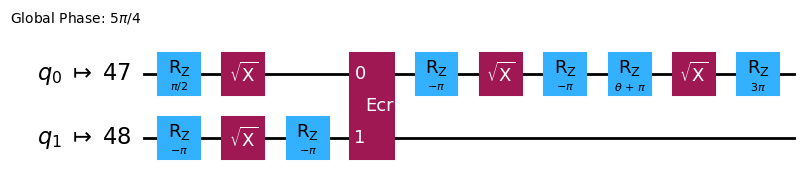

In [ ]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

chsh_isa_circuit = pm.run(chsh_circuit)

isa_observable1 = observable1.apply_layout(layout=chsh_isa_circuit.layout)
isa_observable2 = observable2.apply_layout(layout=chsh_isa_circuit.layout)

chsh_isa_circuit.draw("mpl", idle_wires=False, style="iqp")

# Step 3. Execute


In [15]:
# To run on a local simulator:
# Use the StatevectorEstimator from qiskit.primitives instead.

estimator = EstimatorV2(mode=backend)

pub = (
    chsh_isa_circuit, 
    [[isa_observable1], [isa_observable2]],
    individual_phases,
)

job_result = estimator.run(pubs=[pub]).result()

# tep 4. Post-process

The estimator returns expectation values for both of the observables.

In [16]:
chsh1_est = job_result[0].data.evs[0]
chsh2_est = job_result[0].data.evs[1]

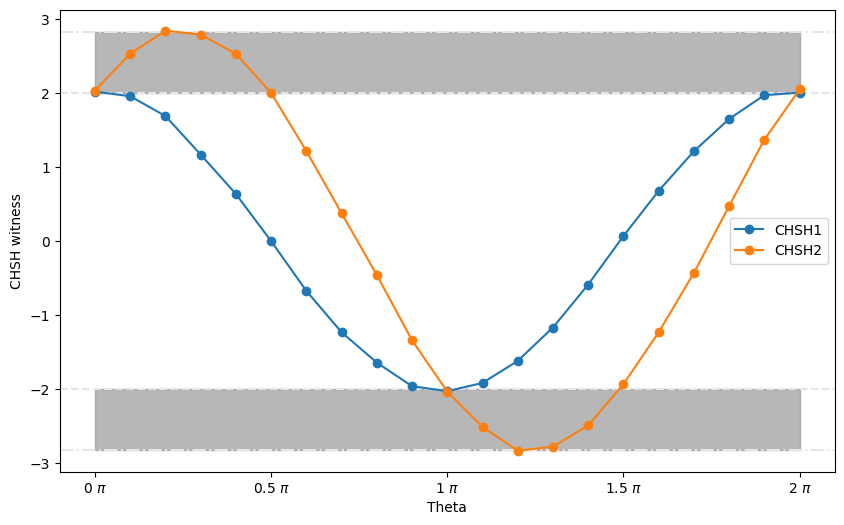

In [17]:
fig, ax = plt.subplots(figsize=(10, 6))

# results from hardware
ax.plot(phases / np.pi, chsh1_est, "o-", label="CHSH1", zorder=3)
ax.plot(phases / np.pi, chsh2_est, "o-", label="CHSH2", zorder=3)

# classical bound +-2
ax.axhline(y=2, color="0.9", linestyle="--")
ax.axhline(y=-2, color="0.9", linestyle="--")

# quantum bound, +-2√2
ax.axhline(y=np.sqrt(2) * 2, color="0.9", linestyle="-.")
ax.axhline(y=-np.sqrt(2) * 2, color="0.9", linestyle="-.")
ax.fill_between(phases / np.pi, 2, 2 * np.sqrt(2), color="0.6", alpha=0.7)
ax.fill_between(phases / np.pi, -2, -2 * np.sqrt(2), color="0.6", alpha=0.7)

# set x tick labels to the unit of pi
ax.xaxis.set_major_formatter(tck.FormatStrFormatter("%g $\\pi$"))
ax.xaxis.set_major_locator(tck.MultipleLocator(base=0.5))

# set labels, and legend
plt.xlabel("Theta")
plt.ylabel("CHSH witness")
plt.legend()
plt.show()